# 通过微分 Z-Vector 方程解决 HF-GGA 过程的 UU 贡献

这份笔记只打算解决 HF-GGA 过程中的项 $E_\mathrm{elec}^{A_t B_s}$ 中所产生的 $\partial_{A_t}^\mathrm{U} \partial_{B_s}^\mathrm{U} E_\mathrm{elec}$。我们以前的笔记中，使用了 Z-Vector 方程的方法，避免二阶 U 矩阵的生成；但事实上，这个方法的计算量仍然达到了生成一阶 U 矩阵的计算大小。在 MP2 的生成过程中，Cammi, R. et al 指出，可以使用“逆向 Z-Vector 过程”来解决这部分较大的计算量。

In [16]:
import numpy as np
from pyscf import scf, gto, lib, grad, hessian, dft
import pyscf.hessian.rks
import pyscf.grad.rks
import matplotlib.pyplot as plt
from functools import partial
from hessian import HFHelper, GGAHelper, NCGGAEngine
from utilities import NumericDiff

np.einsum = partial(np.einsum, optimize=["greedy", 1024 ** 3 * 2 / 8])
np.set_printoptions(5, linewidth=120, suppress=True)

In [2]:
mol = gto.Mole()
mol.atom = """
O  0.0  0.0  0.0
O  0.0  0.0  1.5
H  1.5  0.0  0.0
H  0.0  0.7  1.5
"""
mol.basis = "6-31G"
mol.verbose = 0
mol.build()

def mol_to_grids(mol):
    grids = dft.gen_grid.Grids(mol)
    grids.atom_grid = (99, 590)
    grids.becke_scheme = dft.gen_grid.stratmann
    grids.prune = None
    grids.build()
    return grids
grids = mol_to_grids(mol)

nmo = nao = mol.nao
natm = mol.natm
nocc = mol.nelec[0]
nvir = nmo - nocc
so = slice(0, nocc)
sv = slice(nocc, nmo)
sa = slice(0, nmo)

In [3]:
hfh = HFHelper(mol)
mol_slice=hfh.mol_slice

In [4]:
nch = GGAHelper(mol, "b3lypg", grids, init_scf=False)
ncengine = NCGGAEngine(hfh, nch)
ncengine.get_E_1()

array([[-0.11432,  0.01432,  0.00169],
       [ 0.01147,  0.7441 ,  0.01752],
       [ 0.09712,  0.00267,  0.0172 ],
       [ 0.00573, -0.7611 , -0.03642]])

在这里我们可以得到 HF-B3LYP 的非自恰二阶 Hessian 的结果：

In [5]:
E_2_byengine = ncengine.E_2

我们最终的目标是重复 $\partial_{A_t}^\mathrm{U} \partial_{B_s}^\mathrm{U} E_\mathrm{elec}$ `E_UU_ref`。

In [6]:
E_UU_ref = ncengine.E_UU

In [7]:
E_SU_part_ref = (
    + 4 * np.einsum("Bspi, Atpi -> ABts", hfh.U_1_vo, nch.F_1_mo[:, :, sv, so])
    - 2 * np.einsum("Bspi, Atpi -> ABts", hfh.S_1_mo[:, :, so, so], nch.F_1_mo[:, :, so, so])
)

In [11]:
e = hfh.e
eo, ev = e[so], e[sv]

e_1 = (hfh.B_1 + hfh.Ax0_Core(sa, sa, sv, so)(hfh.U_1_vo)).diagonal(0, -1, -2)
eo_1, ev_1 = e_1[:, :, so], e_1[:, :, sv]

Z_1 = ncengine.Z_1
U_1 = hfh.U_1
U_1_vo = hfh.U_1_vo

## 微分 Z-Vector 方程

In [12]:
E_U_ref = (
    + 4 * np.einsum("Atai, ai -> At", hfh.B_1[:, :, sv, so], Z_1)
    - 2 * np.einsum("Atki, ki -> At", hfh.S_1_mo[:, :, so, so], nch.F_0_mo[so, so])
)

In [13]:
pdA_nch_F_0_mo = (
    + nch.F_1_mo
    + np.einsum("pm, Atmq -> Atpq", nch.F_0_mo, U_1)
    + np.einsum("mq, Atmp -> Atpq", nch.F_0_mo, U_1)
    + nch.Ax0_Core(sa, sa, sa, so)(U_1[:, :, :, so])
)

In [14]:
def mol_to_nch_F_0_mo(mol):
    hfh = HFHelper(mol)
    nch = GGAHelper(mol, "b3lypg", mol_to_grids(mol), init_scf=False)
    ncengine = NCGGAEngine(hfh, nch)
    return nch.F_0_mo
diff_nch_F_0_mo = NumericDiff(mol, mol_to_nch_F_0_mo).get_numdif()

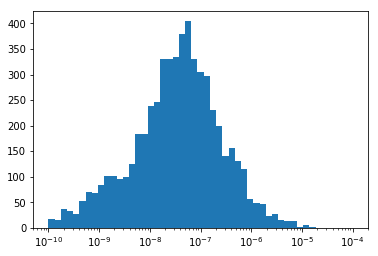

In [17]:
plt.hist(abs(pdA_nch_F_0_mo - diff_nch_F_0_mo).ravel(), bins=np.logspace(np.log10(1e-10),np.log10(1e-4), 50))
plt.gca().set_xscale("log")

In [23]:
pdA_hfh_F_1_mo = (
    + hfh.F_2_mo
    + np.einsum("Atpm, Bsmq -> ABtspq", hfh.F_1_mo, U_1)
    + np.einsum("Atmq, Bsmp -> ABtspq", hfh.F_1_mo, U_1)
    + hfh.Ax1_Core(sa, sa, sa, so)(U_1[:, :, :, so])
)

In [26]:
diff_hfh_F_1_mo = NumericDiff(mol, lambda mol : HFHelper(mol).F_1_mo, deriv=2, symm=False).get_numdif()

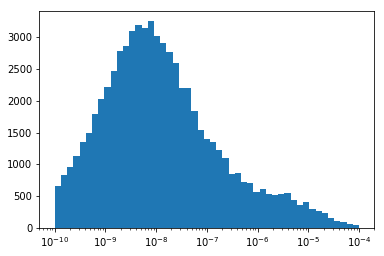

In [29]:
plt.hist(abs(pdA_hfh_F_1_mo - diff_hfh_F_1_mo).ravel(), bins=np.logspace(np.log10(1e-10),np.log10(1e-4), 50))
plt.gca().set_xscale("log")

In [33]:
pdA_hfh_S_1_mo = (
    + hfh.S_2_mo
    + np.einsum("Bsmp, Atmq -> ABtspq", U_1, hfh.S_1_mo)
    + np.einsum("Bsmq, Atpm -> ABtspq", U_1, hfh.S_1_mo)
)

In [30]:
diff_hfh_S_1_mo = NumericDiff(mol, lambda mol : HFHelper(mol).S_1_mo, deriv=2, symm=False).get_numdif()

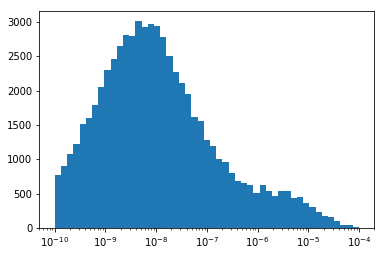

In [32]:
plt.hist(abs(pdA_hfh_S_1_mo - diff_hfh_S_1_mo).ravel(), bins=np.logspace(np.log10(1e-10),np.log10(1e-4), 50))
plt.gca().set_xscale("log")

In [60]:
diff_hfh_e = NumericDiff(mol, lambda mol : HFHelper(mol).e).get_numdif()

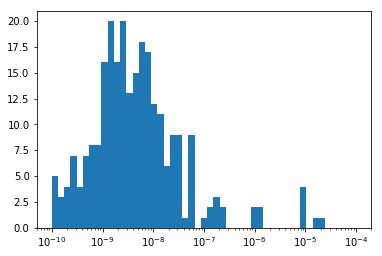

In [61]:
plt.hist(abs(e_1 - diff_hfh_e).ravel(), bins=np.logspace(np.log10(1e-10),np.log10(1e-4), 50))
plt.gca().set_xscale("log")

In [51]:
np.allclose(
    hfh.B_1[:, :, sv, so],
    + hfh.F_1_mo[:, :, sv, so]
    - np.einsum("Atai, i -> Atai", hfh.S_1_mo[:, :, sv, so], eo)
    - 0.5 * hfh.Ax0_Core(sv, so, so, so)(hfh.S_1_mo[:, :, so, so])
)

True

In [84]:
def mol_to_hfh_B_1_vo(mol):
    hfh = HFHelper(mol)
    #return hfh.F_1_mo[:, :, sv, so]
    #return - np.einsum("Atai, i -> Atai", hfh.S_1_mo[:, :, sv, so], hfh.eo)
    #return - 0.5 * hfh.Ax0_Core(sv, so, so, so)(hfh.S_1_mo[:, :, so, so])
    return hfh.B_1[:, :, sv, so]

diff_hfh_B_1_vo = NumericDiff(mol, mol_to_hfh_B_1_vo, deriv=2, symm=False).get_numdif()

In [85]:
pdA_hfh_B_1_vo = (
    + pdA_hfh_F_1_mo[:, :, :, :, sv, so]
    - np.einsum("Atai, Bsi -> ABtsai", hfh.S_1_mo[:, :, sv, so], eo_1)
    - np.einsum("ABtsai, i -> ABtsai", pdA_hfh_S_1_mo[:, :, :, :, sv, so], eo)
    - 0.5 * hfh.Ax1_Core(sv, so, so, so)(hfh.S_1_mo[:, :, so, so]).swapaxes(0, 1).swapaxes(2, 3)
    - 0.5 * np.einsum("Bspa, Atpi -> ABtsai", U_1[:, :, :, sv], hfh.Ax0_Core(sa, so, so, so)(hfh.S_1_mo[:, :, so, so]))
    - 0.5 * np.einsum("Bspi, Atpa -> ABtsai", U_1[:, :, :, so], hfh.Ax0_Core(sa, sv, so, so)(hfh.S_1_mo[:, :, so, so]))
    - 1 * hfh.Ax0_Core(sv, so, sa, so)(np.einsum("Bspk, Atkl -> ABtspl", U_1[:, :, :, so], hfh.S_1_mo[:, :, so, so]))
    - 0.5 * hfh.Ax0_Core(sv, so, so, so)(pdA_hfh_S_1_mo[:, :, :, :, so, so])
)

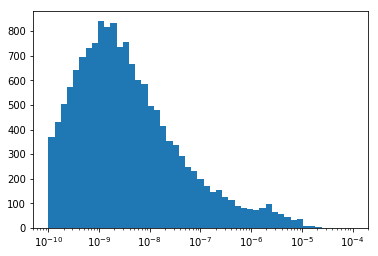

In [86]:
plt.hist(abs(pdA_hfh_B_1_vo - diff_hfh_B_1_vo).ravel(), bins=np.logspace(np.log10(1e-10),np.log10(1e-4), 50))
plt.gca().set_xscale("log")

In [87]:
E_UU_contrib2 = (
    - 2 * np.einsum("Atki, Bski -> ABts", hfh.S_1_mo[:, :, so, so], pdA_nch_F_0_mo[:, :, so, so])
    - 2 * np.einsum("ABtski, ki -> ABts", pdA_hfh_S_1_mo[:, :, :, :, so, so], nch.F_0_mo[so, so])
)

In [88]:
RHS = np.zeros((natm, 3, nvir, nocc))
RHS += pdA_nch_F_0_mo[:, :, sv, so]

RHS += hfh.Ax1_Core(sv, so, sv, so)(np.array([[Z_1]]))[:, 0, :, 0]
RHS += np.einsum("Atpa, pi -> Atai", U_1[:, :, :, sv], hfh.Ax0_Core(sa, so, sv, so)(Z_1))
RHS += np.einsum("Atpi, ap -> Atai", U_1[:, :, :, so], hfh.Ax0_Core(sv, sa, sv, so)(Z_1))
RHS += hfh.Ax0_Core(sv, so, sa, so)(np.einsum("Atmp, pq -> Atmq", U_1[:, :, :, sv], Z_1))
RHS += hfh.Ax0_Core(sv, so, sv, sa)(np.einsum("Atmq, pq -> Atpm", U_1[:, :, :, so], Z_1))

RHS += Z_1 * (ev_1[:, :, :, None] - eo_1[:, :, None, :])

In [97]:
def mol_to_Z_1(mol):
    hfh = HFHelper(mol)
    nch = GGAHelper(mol, "b3lypg", mol_to_grids(mol), init_scf=False)
    ncengine = NCGGAEngine(hfh, nch)
    return ncengine.Z_1
diff_Z_1 = NumericDiff(mol, mol_to_Z_1).get_numdif()

In [98]:
pdA_Z_1 = scf.cphf.solve(hfh.Ax0_Core(sv, so, sv, so), e, hfh.mo_occ, RHS, max_cycle=100, tol=1e-13)[0].reshape(natm, 3, nvir, nocc)

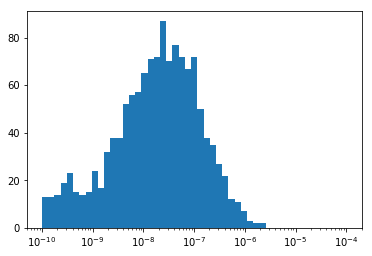

In [99]:
plt.hist(abs(pdA_Z_1 - diff_Z_1).ravel(), bins=np.logspace(np.log10(1e-10),np.log10(1e-4), 50))
plt.gca().set_xscale("log")

In [102]:
E_UU_contrib1 = (
    + 4 * np.einsum("Atai, Bsai -> ABts", hfh.B_1[:, :, sv, so], pdA_Z_1)
    + 4 * np.einsum("ABtsai, ai -> ABts", pdA_hfh_B_1_vo, Z_1)
)

In [103]:
E_UU_contrib2 = (
    - 2 * np.einsum("Atki, Bski -> ABts", hfh.S_1_mo[:, :, so, so], pdA_nch_F_0_mo[:, :, so, so])
    - 2 * np.einsum("ABtski, ki -> ABts", pdA_hfh_S_1_mo[:, :, :, :, so, so], nch.F_0_mo[so, so])
)

In [105]:
np.allclose(
    E_UU_contrib1 + E_UU_contrib2 + E_SU_part_ref,
    ncengine.E_SU + ncengine.E_UU
)

True